### imports

In [1]:
import random
import os
import csv

import numpy as np
import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

import nltk
import gensim.downloader as api

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split

import kagglehub

In [2]:
class Colour:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

vscode_bg = '#1e1e1e'
text_color = 'white'
grid_color = '#444444'

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Consolas', 'DejaVu Sans Mono', 'Courier New']
plt.rcParams['figure.facecolor'] = vscode_bg
plt.rcParams['axes.facecolor'] = vscode_bg
plt.rcParams['axes.edgecolor'] = text_color
plt.rcParams['axes.labelcolor'] = text_color
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['text.color'] = text_color
plt.rcParams['grid.color'] = grid_color

### load data

In [3]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)
nltk.download('punkt_tab')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Path to dataset files: /Users/valentin/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/valentin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Preprocess

### prepare data

In [4]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        # specials tokens
        self.add_word('<pad>')
        self.add_word('<unk>')
        self.add_word('<start>')
        self.add_word('<end>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def encode(self, text):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        return [self.word2idx.get(t, self.word2idx['<unk>']) for t in tokens]

In [5]:
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, vocab, cache_dir):
        self.data_pairs = data_pairs
        self.vocab = vocab
        self.cache_dir = cache_dir
        
    def __len__(self): return len(self.data_pairs)
    
    def __getitem__(self, idx):
        img_path, caption = self.data_pairs[idx]
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(self.cache_dir, filename)
        
        try:
            cached = torch.load(load_path)
            feat = cached['features'] if isinstance(cached, dict) else cached
            if len(feat.shape) > 1: feat = feat[0]
        except FileNotFoundError:
            feat = torch.zeros(512) # fallback

        tokens = self.vocab.encode(caption)
        caption_indices = [self.vocab.word2idx['<start>']] + tokens + [self.vocab.word2idx['<end>']]
        return feat, torch.tensor(caption_indices, dtype=torch.long)

In [6]:
class DataManager:
    def __init__(self, dataset_path, img_folder_name="flickr30k_images", captions_filename="captions.txt", cache_dir="cached_features"):
        self.root = dataset_path
        self.img_folder = os.path.join(self.root, img_folder_name)
        self.captions_file = self._find_file(captions_filename)
        self.token_file = os.path.join(self.root, "flickr30k.token.txt")
        self.cache_dir = cache_dir
        self.vocab = Vocab()
        self.data_pairs = []
        
    def _find_file(self, name):
        for root, _, files in os.walk(self.root):
            if name in files: return os.path.join(root, name)
        return None

    def prepare_data(self, limit=None, vocab_max_size=None):
        """Pipeline complet : CSV -> Token -> Vocab -> Pairs"""
        if not os.path.exists(self.token_file):
            self._convert_csv_to_token()
            
        with open(self.token_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        random.seed(42)
        random.shuffle(lines)
        
        count = 0
        for line in lines:
            if limit and count >= limit: break
            
            parts = line.strip().split('\t')
            if len(parts) < 2: continue
            
            img_id = parts[0].split('#')[0]
            caption = parts[1]
            img_path = os.path.join(self.img_folder, img_id)
            
            if os.path.exists(img_path):
                self.data_pairs.append((img_path, caption))
                for w in nltk.tokenize.word_tokenize(caption.lower()):
                    if vocab_max_size and len(self.vocab) >= vocab_max_size: continue
                    self.vocab.add_word(w)
                count += 1
                
        print(f"{Colour.GREEN}✅ Data loaded:{Colour.END} {Colour.BOLD}{len(self.data_pairs)}{Colour.END} pairs | {Colour.BOLD}{len(self.vocab)}{Colour.END} vocab words")

    def _convert_csv_to_token(self):
        try:
            with open(self.captions_file, 'r', encoding='utf-8') as infile, \
                 open(self.token_file, 'w', encoding='utf-8') as outfile:
                reader = csv.reader(infile)
                next(reader)
                for row in reader:
                    if len(row) == 3:
                        outfile.write(f"{row[0]}#{row[1]}\t{row[2]}\n")
        except Exception as e:
            print(f"{Colour.RED}❌ Conversion error:{Colour.END} {e}")
    
    def caption_collate_fn(self, batch):
        imgs, caps = zip(*batch)
        imgs = torch.stack(imgs)
        caps_padded = pad_sequence(caps, batch_first=True, padding_value=0)
        return imgs, caps_padded

    def get_loaders(self, batch_size=64, test_size=0.2):
        """Divise par IMAGE et renvoie les DataLoaders"""
        img_to_caps = {}
        for img, cap in self.data_pairs:
            if img not in img_to_caps: img_to_caps[img] = []
            img_to_caps[img].append(cap)
            
        unique_imgs = list(img_to_caps.keys())
        train_imgs, test_imgs = train_test_split(unique_imgs, test_size=test_size, random_state=42)
        
        train_pairs = [(img, cap) for img in train_imgs for cap in img_to_caps[img]]
        test_pairs = [(img, cap) for img in test_imgs for cap in img_to_caps[img]]
        
        print(f"{Colour.CYAN}📊 Split:{Colour.END} Train {Colour.BOLD}{len(train_pairs)}{Colour.END} | Test {Colour.BOLD}{len(test_pairs)}{Colour.END}")
        
        train_ds = CaptionDataset(train_pairs, self.vocab, self.cache_dir)
        test_ds = CaptionDataset(test_pairs, self.vocab, self.cache_dir)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=self.caption_collate_fn, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=self.caption_collate_fn, drop_last=True)
        
        return train_loader, test_loader, train_pairs, test_pairs


In [7]:
data_manager = DataManager(path)
data_manager.prepare_data(limit=26000, vocab_max_size=5000)
train_loader, test_loader, train_pairs, test_pairs = data_manager.get_loaders(batch_size=100)
vocab = data_manager.vocab

✅ Data loaded: 26000 pairs | 5000 vocab words
📊 Split: Train 20855 | Test 5145


# Alignment

### alignment computation

In [8]:
def resize_pad(img, size=224):
    w, h = img.size
    max_wh = max(w, h)
    pad_w = (max_wh - w) // 2
    pad_h = (max_wh - h) // 2
    padding = (pad_w, pad_h, max_wh - w - pad_w, max_wh - h - pad_h)
    return T.Resize((size, size))(TF.pad(img, padding, fill=0))

def load_word2vec_embeddings(vocab, embed_dim=300):
    w2v_model = api.load('word2vec-google-news-300')
    vocab_size = len(vocab)
    weights_matrix = np.zeros((vocab_size, embed_dim))

    hits = 0
    misses = 0

    for word, idx in vocab.word2idx.items():
        if word in w2v_model:
            weights_matrix[idx] = w2v_model[word]
            hits += 1
        else:
            weights_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))
            misses += 1
    return torch.tensor(weights_matrix, dtype=torch.float32)

In [9]:
def get_features(img_path, detection_model, device='cpu', threshold=0.5):
    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    
    preprocess = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = T.ToTensor()(img_pil).to(device)
    detection_model.eval()
    with torch.no_grad():
        output = detection_model([img_tensor])
        pred = output[0]

    keep = pred['scores'] > threshold
    final_boxes = pred['boxes'][keep][:19]
    backbone = detection_model.backbone.body 
    
    def extract_vector(image):
        with torch.no_grad():
            outputs = backbone(image.to(device))
            feats = outputs['3'] 
            
            vec = F.adaptive_avg_pool2d(feats, (1, 1)).flatten()
            return vec.cpu().numpy()

    regions_features = []
    
    full_img_vec = extract_vector(preprocess(img_pil).unsqueeze(0))
    regions_features.append(full_img_vec)

    for box in final_boxes:
        x1, y1, x2, y2 = box.int().tolist()
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w_img, x2), min(h_img, y2)
        
        if x2 - x1 < 5 or y2 - y1 < 5: continue
        
        crop = img_pil.crop((x1, y1, x2, y2))
        regions_features.append(extract_vector(preprocess(crop).unsqueeze(0)))

    return regions_features, final_boxes

### precompute features

the function below extractw features from image regions and save them to a .pt file, so that they can be loaded quickly during training or evaluation.

In [10]:
def precompute_features(data_pairs, detection_model, device, cache_dir="cached_features"):
    os.makedirs(cache_dir, exist_ok=True)
    unique_img_paths = list(set([path for path, caption in data_pairs]))

    detection_model.eval()
    for img_path in tqdm(unique_img_paths):
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        save_path = os.path.join(cache_dir, filename)
        if os.path.exists(save_path):
            continue

        try:
            feats_np, boxes = get_features(img_path, detection_model, device)
            data_to_save = {
                'features': torch.tensor(feats_np).float().cpu(),
                'boxes': boxes.cpu()
            }
            torch.save(data_to_save, save_path)
        except Exception as e:
            print(f"{Colour.RED}error on {img_path}: {e}{Colour.END}")

# uncomment to precompute features (already done):
# precompute_features(train_pairs, resnet, DEVICE)

### alignement model

In [11]:
class AlignmentModel(nn.Module):
    def __init__(self, vocab_size, word_embed_size, image_feature_size, hidden_size, pretrained_embeddings=None):
        super().__init__()
        self.image_projection = nn.Linear(image_feature_size, hidden_size)
        if pretrained_embeddings is not None:
            self.word_embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        else:
            self.word_embedding = nn.Embedding(vocab_size, word_embed_size)
        self.embedding_projection = nn.Linear(word_embed_size, hidden_size)

        self.brnn = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.text_projection = nn.Linear(hidden_size * 2, hidden_size)

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)

    def forward(self, region_features, captions):
        img_emb = self.image_projection(region_features)
        img_emb = F.relu(img_emb)

        x_t = self.word_embedding(captions)
        e_t = F.relu(self.embedding_projection(x_t))
        rnn_out, _ = self.brnn(e_t)

        txt_emb = self.text_projection(rnn_out)
        txt_emb = F.relu(txt_emb)

        img_emb = F.normalize(img_emb, p=2, dim=-1)
        txt_emb = F.normalize(txt_emb, p=2, dim=-1)

        return img_emb, txt_emb

### loss

In [12]:
class ContrastiveRankingLoss(nn.Module):
    def __init__(self, margin=0.2):
        super().__init__()
        self.margin = margin

    def forward(self, img_emb, txt_emb, txt_mask):
        scores_map = torch.einsum('bih,cjh->bcij', img_emb, txt_emb)
        max_region_scores, _ = torch.max(scores_map, dim=2)
        mask_expanded = txt_mask.unsqueeze(0).expand(max_region_scores.size(0), -1, -1)
        max_region_scores = max_region_scores * mask_expanded
        scores = torch.sum(max_region_scores, dim=2)

        diagonal = scores.diag().view(-1, 1)
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)

        cost_s = (self.margin + scores - d1).clamp(min=0)
        cost_im = (self.margin + scores - d2).clamp(min=0)

        mask = torch.eye(scores.size(0), device=scores.device) > .5

        cost_s = cost_s.masked_fill_(mask, 0)
        cost_im = cost_im.masked_fill_(mask, 0)

        return cost_s.sum() + cost_im.sum()

### train one epoch

In [13]:
def train_one_alignment_epoch(data_pairs, vocab, model, optimizer, device, cache_dir="cached_features", batch_size=64):
    model.train()
    criterion = ContrastiveRankingLoss(margin=0.5)
    total_loss = 0
    count_batches = 0

    batch_imgs = []
    batch_caps = []
    random.shuffle(data_pairs)
    pbar = tqdm.tqdm(data_pairs)

    for img_path, caption in pbar:
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(cache_dir, filename)
        try:
            cached_data = torch.load(load_path)
            feats_tensor = cached_data['features'] 
        except FileNotFoundError:
            continue

        MAX_FEATURES = 20
        current_num_features = feats_tensor.shape[0]
        if current_num_features < MAX_FEATURES:
            padding = torch.zeros((MAX_FEATURES - current_num_features, 2048), dtype=torch.float32)
            if current_num_features == 0:
                padded_feats = padding
            else:
                padded_feats = torch.cat([feats_tensor, padding], dim=0)
        else:
            padded_feats = feats_tensor[:MAX_FEATURES]

        batch_imgs.append(padded_feats)

        txt_indices = vocab.encode(caption)
        batch_caps.append(torch.tensor(txt_indices).long())

        if len(batch_imgs) >= batch_size:
            optimizer.zero_grad()

            img_tensor = torch.stack(batch_imgs).to(device)
            txt_tensor = torch.nn.utils.rnn.pad_sequence(batch_caps, batch_first=True, padding_value=0).to(device)
            txt_mask = (txt_tensor != 0).float().to(device)

            img_emb, txt_emb = model(img_tensor, txt_tensor)
            
            loss = criterion(img_emb, txt_emb, txt_mask)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            total_loss += loss.item()
            count_batches += 1
            pbar.set_description(f"Loss: {loss.item():.4f}")

            batch_imgs = []
            batch_caps = []

    return total_loss / max(count_batches, 1)

### rcnn model

In [14]:
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(DEVICE)   # pretrained=True
resnet.eval()

print(f"{Colour.GREEN}✅ Model loaded{Colour.END}")
print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Model loaded
💻 Device: CPU


In [15]:
EMBED_DIM = 300
HIDDEN_SIZE = 512
w2v_weights = load_word2vec_embeddings(vocab, embed_dim=EMBED_DIM)
w2v_weights = w2v_weights.to(DEVICE)

In [16]:
pretrained_model = False

if pretrained_model:
    model_align = torch.load("saved_models/alignment_model.pt").to(DEVICE)
    print(f"{Colour.GREEN}✅ Pretrained model loaded{Colour.END}")
else:
    model_align = AlignmentModel(vocab_size=len(vocab),
        word_embed_size=EMBED_DIM,
        image_feature_size=2048,
        hidden_size=HIDDEN_SIZE,
        pretrained_embeddings=w2v_weights
    )
    model_align.init_weights()
    model_align.to(DEVICE)
    
    optimizer = torch.optim.Adam(model_align.parameters(), lr=1e-4)

    train_losses = []
    epoch = 0
    print(f"{Colour.GREEN}✅ Model initialized{Colour.END}")

    criterion_captioning = nn.CrossEntropyLoss(ignore_index=vocab.word2idx.get('<pad>', 0))

    print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Model initialized
💻 Device: CPU


### training loop

In [17]:
if not pretrained_model:
    epoch_max = 3
    # epoch_max = 70

    print(f"{Colour.CYAN}🚀 Training on {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

    while epoch < epoch_max:
        print(f"\n{Colour.BOLD}=== Epoch {epoch+1}/{epoch_max} ==={Colour.END}")
        
        avg_loss = train_one_alignment_epoch(train_pairs, vocab, model_align, optimizer, DEVICE, cache_dir="cached_features", batch_size=256)
        train_losses.append(avg_loss)
        if len(train_losses) == 0 or len(train_losses) == 1:
            print(f"{Colour.GREEN}📉 Avg Loss: {Colour.BOLD}{avg_loss:.4f}{Colour.END}")
        elif train_losses[-2] > train_losses[-1]:
            print(f"{Colour.GREEN}📉 Avg Loss: {Colour.BOLD}{avg_loss:.4f}{Colour.END}")
        else:
            print(f"{Colour.RED}📉 Avg Loss: {Colour.BOLD}{avg_loss:.4f}{Colour.END} (did not improve)")
        epoch += 1

    print(f"\n{Colour.GREEN}✅ Training complete!{Colour.END}")

🚀 Training on CPU

=== Epoch 1/3 ===


Loss: 37362.1562: 100%|██████████| 20855/20855 [01:02<00:00, 331.59it/s]


📉 Avg Loss: 53909.0345

=== Epoch 2/3 ===


Loss: 22975.9531: 100%|██████████| 20855/20855 [00:56<00:00, 369.74it/s]


📉 Avg Loss: 26322.9890

=== Epoch 3/3 ===


Loss: 17236.7051: 100%|██████████| 20855/20855 [00:56<00:00, 366.46it/s]

📉 Avg Loss: 16172.7983

✅ Training complete!


In [18]:
def plot_training_loss_alignment(train_losses):
    if not train_losses:
        print(f"{Colour.YELLOW}[WARNING] No training loss data to plot.{Colour.END}")
        return

    epochs = range(1, len(train_losses) + 1)

    fig, ax = plt.subplots(figsize=(10, 6), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)
    line_color = "#0b5192"
    ax.plot(epochs, train_losses, marker='o', 
            linewidth=2, 
            markersize=6, 
            color=line_color, 
            markerfacecolor=line_color,
            label='Train Loss')

    ax.fill_between(epochs, train_losses, alpha=0.3, color=line_color)
    plt.xlabel('Epoch', fontsize=12, color=text_color, family='monospace')
    plt.ylabel('Loss', fontsize=12, color=text_color, family='monospace')
    plt.title('Training Loss Over Epochs', fontsize=14, color=text_color, pad=15, family='monospace')

    ax.tick_params(axis='both', colors=text_color, labelsize=10, length=6, width=1.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(text_color)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color(text_color)
    ax.spines['bottom'].set_linewidth(1.2)

    ax.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.2, color='white')

    if len(train_losses) <= 20:
        ax.set_xticks(epochs)
    else:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.set_xlim(1, max(epochs) if len(epochs) > 0 else 1)
    ax.set_ylim(0, None)
        
    plt.tight_layout()

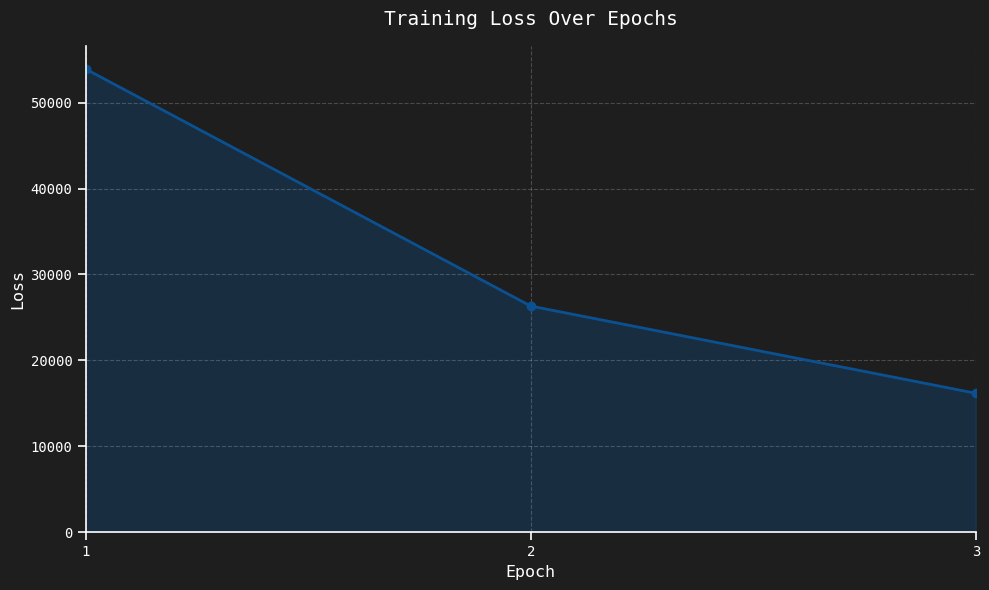

In [19]:
plot_training_loss_alignment(train_losses)

# Visualization

In [25]:
def visualize_alignment(img_path, caption, detection_model, model_align, vocab, device, threshold=0.5, dist_test=40):
    model_align.eval()
    region_feats_list, boxes = get_features(img_path, detection_model, device, threshold)
    if len(boxes) == 0:
        print(f"{Colour.RED}[ERROR] No objects detected in image.{Colour.END}")
        return
    img_features = torch.tensor(np.array(region_feats_list)).float().to(device).unsqueeze(0) 
    
    words = nltk.word_tokenize(caption.lower())
    stop_words = {'.', ',', 'a', 'the', 'is', 'are', 'in', 'on', 'of', 'and', 'with', 'to', 'at'}
    meaningful_words = [w for w in words if w not in stop_words]
    
    if not meaningful_words:
        print(f"{Colour.YELLOW}[WARNING] No meaningful words found.{Colour.END}")
        return
    
    word_indices = [vocab.word2idx.get(w, vocab.word2idx['<unk>']) for w in meaningful_words]
    txt_tensor = torch.tensor(word_indices).long().to(device).unsqueeze(0)

    with torch.no_grad():
        img_emb, txt_emb = model_align(img_features, txt_tensor)
    
    scores = torch.matmul(img_emb[0], txt_emb[0].t()).cpu().numpy()
    
    best_indices = scores.argmax(axis=0) # Best region index for each word
    best_scores = scores.max(axis=0)     # Best score value for each word

    img_pil = Image.open(img_path).convert("RGB")
    w_img, h_img = img_pil.size
    
    vscode_bg = '#1e1e1e'
    text_color = 'white'
    
    fig, ax = plt.subplots(figsize=(14, 8), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)

    ax.imshow(img_pil)
    colors = cm.tab20(range(len(meaningful_words)))
    
    text_x_start = w_img + (w_img * 0.05)
    for i, (word, best_idx, score) in enumerate(zip(meaningful_words, best_indices, best_scores)):
        color = colors[i]
        if best_idx < len(boxes):
            box = boxes[best_idx].cpu().numpy() if isinstance(boxes[best_idx], torch.Tensor) else boxes[best_idx]
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2.5, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            target_x, target_y = (x1 + x2) / 2, (y1 + y2) / 2
        else:
            target_x, target_y = w_img / 2, h_img / 2

        text_y = (i * dist_test) + (h_img * 0.05)
        label_text = f"{word} ({score:.2f})"
        
        ax.text(text_x_start, text_y, label_text, 
                fontsize=13, fontweight='bold', color='black', 
                va='center', ha='left', family='monospace',
                bbox=dict(boxstyle='square,pad=0.4', facecolor=color, edgecolor='none', alpha=0.9))
        if score > 0.0: 
            ax.annotate('', 
                        xy=(target_x, target_y), 
                        xytext=(text_x_start, text_y),
                        arrowprops=dict(arrowstyle='->', color=color, linewidth=2, mutation_scale=15))

    ax.set_xlim(0, w_img * 1.6) 
    ax.set_ylim(h_img, 0)
    ax.axis("off")
    
    plt.tight_layout()
    plt.show()

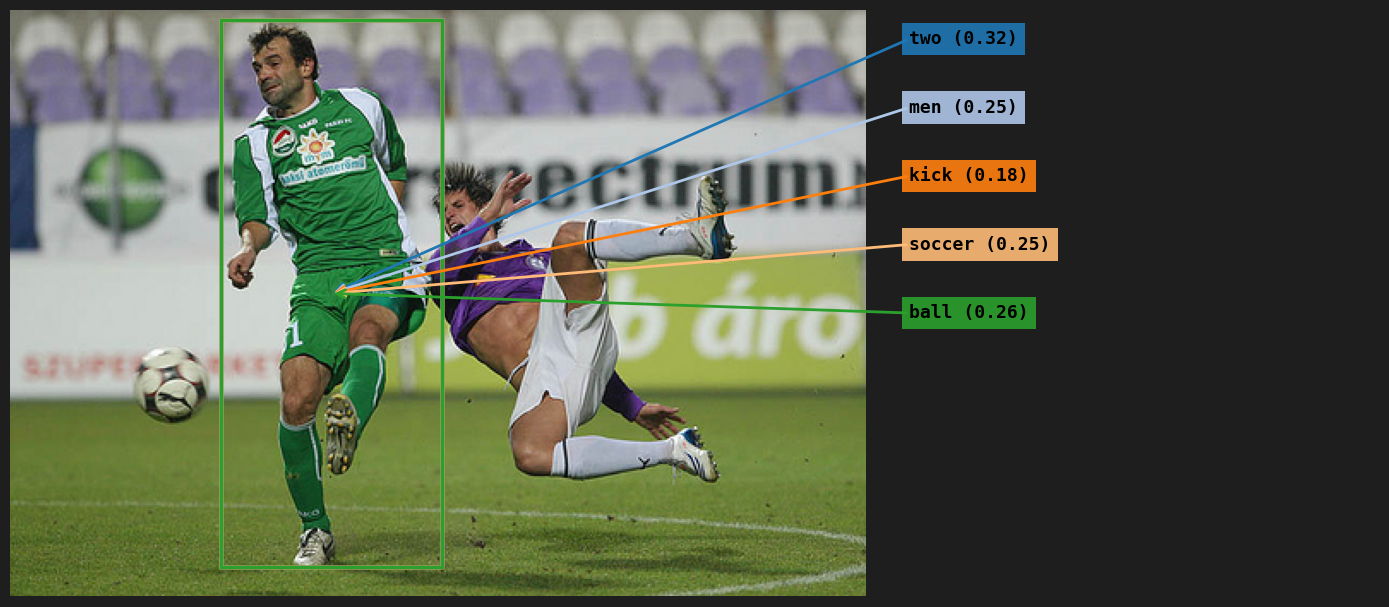

In [28]:
img_path, caption = random.choice(train_pairs)
visualize_alignment(img_path, caption, resnet, model_align, vocab, DEVICE, threshold=0.5, dist_test=40)